In [1]:
import numpy as np
import pandas as pd
import random
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
%matplotlib inline

# qiskit modules
import qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector, plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity, DensityMatrix
from qiskit.providers.aer.noise import NoiseModel

# tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

# readout calibration
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [2]:
# importing IBMQ backends
from qiskit import IBMQ
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
device = ibmq_provider.get_backend('ibmq_16_melbourne') #ibmqx2 ibmq_16_melbourne ibmq_ourense ibmq_burlington

# necessary imports for noise modelling
noise_model = NoiseModel.from_backend(device)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

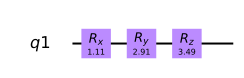

In [4]:
R=[]
for i in range(3):
    R.append(10*random.random()) 
n=3
qreg = QuantumRegister(n)
qreg_exp = QuantumRegister(1)
qc_expected = QuantumCircuit(qreg_exp)
qc_expected.rx(np.pi/5*R[0],0)
qc_expected.ry(np.pi/5*R[1],0)
qc_expected.rz(np.pi/5*R[2],0)
qc_expected.draw(output='mpl')

The expected state is: [ 0.53403457+0.j         -0.3723169 +0.75906996j]


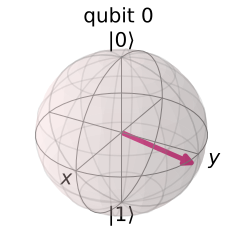

In [5]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_bloch_multivector(psi_expected)

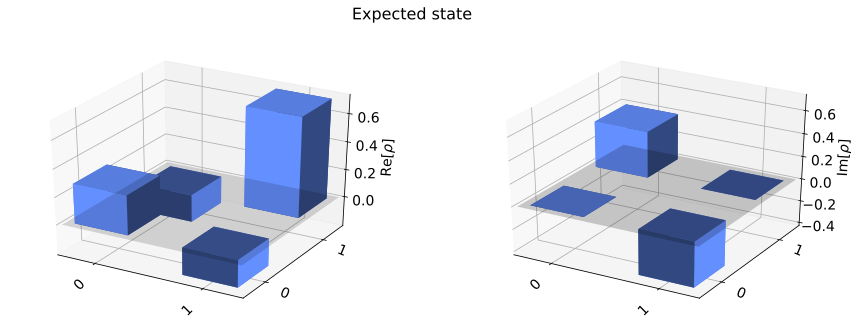

In [6]:
plot_state_city(psi_expected, title='Expected state')

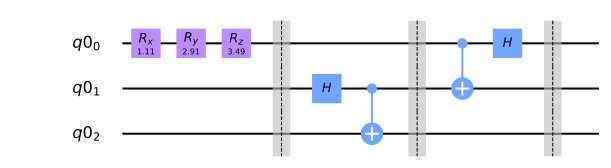

In [7]:
qc = QuantumCircuit(qreg)
qc.rx(np.pi/5*R[0],0)
qc.ry(np.pi/5*R[1],0)
qc.rz(np.pi/5*R[2],0)
qc.barrier()
qc.h(1)
qc.cx(1,2)
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.draw(output='mpl')

In [8]:
# defining the tomography circuits
qst_full_circuits = state_tomography_circuits(qc,qreg)
# the three circuits are in the order [ZZX, ZZY, ZZZ]
qst_circuit = [qst_full_circuits[24], qst_full_circuits[25], qst_full_circuits[26]]

In [9]:
bits = ['000', '100', '001', '101', '010', '110', '011', '111']

backends = ['simulator', 'simulator_noise', device]
paulis = [('Z','Z','X'), ('Z','Z','Y'), ('Z','Z','Z')]
basis = ['X', 'Y', 'Z']

for num, backend in enumerate(backends):
    state = {'X': {'0': 0, '1': 0}, 'Y': {'0': 0, '1': 0}, 'Z': {'0': 0, '1': 0}}
    state_df = pd.DataFrame(data=[state,state,state,state])
    if num == 0:
        job_sim = qiskit.execute(qst_circuit, Aer.get_backend('qasm_simulator'), shots=8192)
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 1:
        job_sim = qiskit.execute(qst_circuit, Aer.get_backend('qasm_simulator'), shots=8192,
                                 noise_model=noise_model, 
                                 coupling_map=coupling_map, 
                                 basis_gates=basis_gates)
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 2:
        job_dev = qiskit.execute(qst_circuit, backend, shots=8192)
        job_monitor(job_dev)
        tom = StateTomographyFitter(job_dev.result(), qst_circuit)
    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit] = 0
    
    # 4 possible outcomes of teleport protocol, where the final state is either
    # psi, X @ psi, Z @ psi, X @ Z @ psi. We store all 4 seperately, to then transform
    # the resulting density matrices appropriately before finding fidelity
    for i in range(4):
        for j in range(3):
            state_df.loc[i][basis[j]] = {'0': tom.data[(paulis[j])][bits[2*i]],
                                         '1': tom.data[(paulis[j])][bits[2*i+1]]}
    if num == 0:
        state_sim = state_df
        print('The full state for the simulator is', state_sim)
    if num == 1:
        state_sim_noise = state_df
        print('The full state for the noisy simulator is', state_sim_noise)
    if num == 2:
        state_dev = state_df
        print('The full state for the device is', state_dev)

The full state for the simulator is                        X                      Y                      Z
0  {'0': 589, '1': 1419}  {'0': 1817, '1': 208}  {'0': 628, '1': 1460}
1  {'0': 1481, '1': 616}  {'0': 178, '1': 1913}  {'0': 570, '1': 1517}
2  {'0': 617, '1': 1439}  {'0': 205, '1': 1825}  {'0': 1485, '1': 556}
3  {'0': 1392, '1': 639}  {'0': 1879, '1': 167}  {'0': 1425, '1': 551}
The full state for the noisy simulator is                        X                      Y                      Z
0  {'0': 914, '1': 1286}  {'0': 1890, '1': 362}  {'0': 857, '1': 1323}
1  {'0': 1434, '1': 592}  {'0': 517, '1': 1584}  {'0': 776, '1': 1237}
2  {'0': 799, '1': 1260}  {'0': 464, '1': 1489}  {'0': 1447, '1': 566}
3  {'0': 1353, '1': 554}  {'0': 1647, '1': 239}  {'0': 1421, '1': 565}
Job Status: job has successfully run
The full state for the device is                        X                      Y                      Z
0  {'0': 804, '1': 1455}  {'0': 1731, '1': 481}  {'0': 938, '1': 1258}


In [10]:
# #readout calibration measurements
# cal_circuits, state_labels = complete_meas_cal(qr = qc.qregs[0], circlabel = 'measerrormitcal')
# cal_job = qiskit.execute(cal_circuits,backend = device,shots = 8192, optimization_level = 0)
# job_monitor(cal_job)
# calres = cal_job.result()
# meas_fitter = CompleteMeasFitter(calres, state_labels)
# meas_fitter.plot_calibration()

In [11]:
# counts =[0,0,0,0,0,0,0,0]
# for num, bbit in enumerate(bits):
#     counts[num]=calres.get_counts(cal_circuits[num])
#     for bit in bits:
#         if bit not in counts[num]:
#             counts[num][bit] = 0

# count = {'00': 0, '01': 0, '10': 0, '11': 0}
# for j in range(4):
#     for num, bit in enumerate(bits):
#         if num%2 == 0:
#             count['00'] += counts[j][bit]
#             count['10'] += counts[j+4][bit]
#         if num%2 == 1:
#             count['01'] += counts[j][bit]
#             count['11'] += counts[j+4][bit]

# epsilon01 = count["01"]/(8192*8)
# epsilon10 = count["10"]/(8192*8)

# beta0 = (epsilon10-epsilon01)
# beta1 = 1-epsilon10-epsilon01
# # plot_histogram(countsdev)

# print('The value of beta 0:', beta0)
# print('The value of beta 1:', beta1)
# # The value of beta 0: 0.0463409423828125
# # The value of beta 1: 0.9501800537109375

In [12]:
beta0 = 0.0463409423828125
beta1 = 0.9501800537109375

In [13]:
# fidelity processing for sim and dev
Iden = np.matrix('1, 0; 0, 1')
XPaul = np.matrix('0, 1; 1, 0')
YPaul = np.matrix('0, 0-1j; 0+1j, 0')
ZPaul = np.matrix('1, 0; 0, -1')

state_tot=[state_sim,state_sim_noise,state_dev,0]
rho2=[0,0,0,0]
r_tot=np.zeros((4, 3))
for k,states in enumerate(state_tot):
    rho_tot=[0,0,0,0]
    if k == 3:
        r_tot[:,:] = (r_tot[:,:] - beta0) / beta1
    else:
        for i in range(4):
            for j in range(3):
                r_tot[i,j] = (state_tot[k][basis[j]][i]['0']*1 + state_tot[k][basis[j]][i]['1']*(-1))/(state_tot[k][basis[j]][i]['0'] + state_tot[k][basis[j]][i]['1'])
    for i in range(4):
        rho_tot[i] = (1/2)*(Iden+r_tot[i,0]*XPaul+r_tot[i,1]*YPaul+r_tot[i,2]*ZPaul)
    rho2[k]=rho_tot
rho = pd.DataFrame(data=[rho2[0],rho2[1],rho2[2],rho2[3]])
for ind in range(4):
    rho.loc[ind][1] = ZPaul @ rho.loc[ind][1] @ ZPaul
    rho.loc[ind][2] = XPaul @ rho.loc[ind][2] @ XPaul
    rho.loc[ind][3] = ZPaul @ XPaul @ rho.loc[ind][3] @ XPaul @ ZPaul

In [14]:
Fidelity = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        Fidelity[i,j] = state_fidelity(psi_expected, rho[j][i], validate=False)      
F = np.mean(Fidelity,axis=1)
print('Simulator Fidelity:', F[0])
print('Noisy Simulator Fidelity:', F[1])
print('Device Fidelity:', F[2])
print('Corrected Device Fidelity:', F[3])

Simulator Fidelity: 1.0036002232309433
Noisy Simulator Fidelity: 0.8805203290425652
Device Fidelity: 0.8598532402320426
Corrected Device Fidelity: 0.8787211053595918


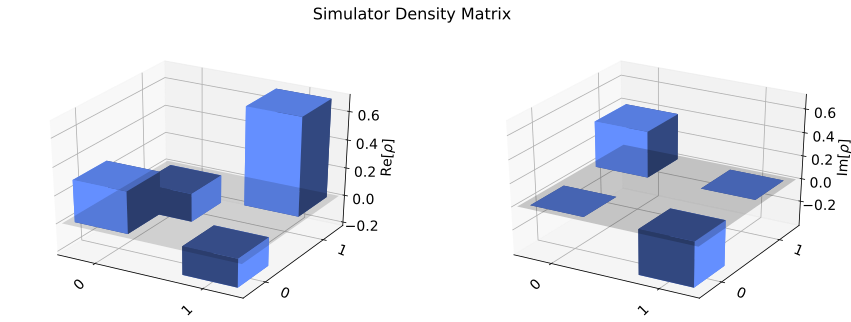

In [15]:
plot_state_city(rho[0][0], title='Simulator Density Matrix')

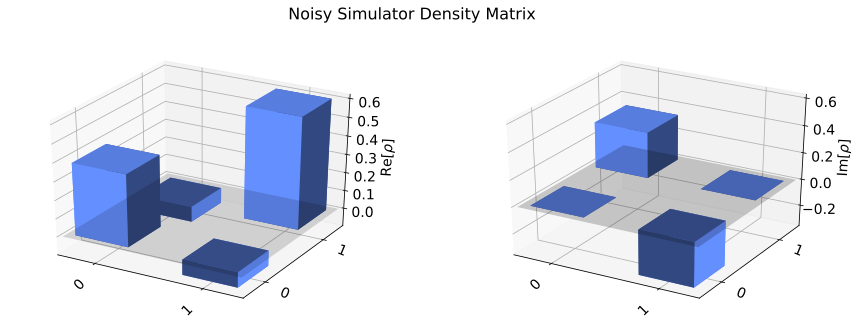

In [16]:
plot_state_city(rho[0][1], title='Noisy Simulator Density Matrix')

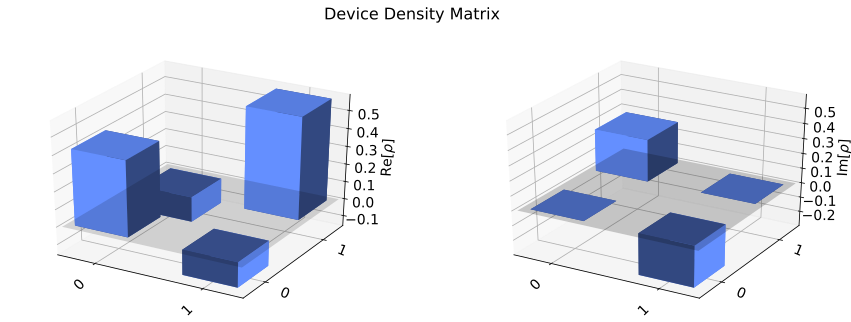

In [17]:
plot_state_city(rho[0][2], title='Device Density Matrix')

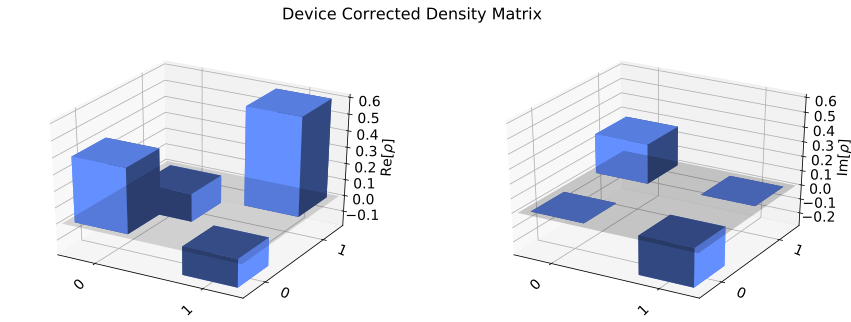

In [18]:
plot_state_city(rho[0][3], title='Device Corrected Density Matrix')

In [19]:
# checking validity of the density matrices, little problem with the simulator one...
for j in range(4):
    for i in range(4):
        rho[i][j] = DensityMatrix(rho[i][j])

# rho_sim = DensityMatrix(rho[0][0])
# rho_dev = DensityMatrix(rho[0][2])

In [20]:
valid = []
for j in range(4):
    for i in range(4):
        valid.append(rho[i][j].is_valid())

In [21]:
# print('Is the ideal simulator density matrix valid?', rho_sim.is_valid())
# print('Is the device density matrix valid?', rho_dev.is_valid())
print('Are all density matrices valid?', all(valid))

Are all density matrices valid? False


In [22]:
import qiskit.tools.jupyter
%qiskit_version_table

In [23]:
# IBMQ.providers()

In [24]:
# IBMQ.active_account()

In [25]:
# IBMQ.delete_account()